# Parameter estimation

`DiffEqParamEstim.jl` is not installed by default with `DifferentialEquations.jl`. You can install it via the following script:

```julia
using Pkg
Pkg.add("DiffEqParamEstim")
using DiffEqParamEstim
```



## Estimate a single parameter from the data and the ODE model

Let's optimize the parameters of the Lotka-Volterra equation.

In [1]:
using DifferentialEquations
using Plots
using DiffEqParamEstim
using Optim

In [2]:
function lotka_volterra!(du, u, p, t)
    du[1] = dx = p[1]*u[1] - u[1]*u[2]
    du[2] = dy = -3*u[2] + u[1]*u[2]
end

lotka_volterra! (generic function with 1 method)

In [3]:
u0 = [1.0;1.0]
tspan = (0.0,10.0)
p = [1.5]
prob = ODEProblem(lotka_volterra!, u0, tspan, p)
sol = solve(prob, Tsit5())

ts = range(0, stop=10, length=200)

0.0:0.05025125628140704:10.0

We build a sample data with some randomness.

In [4]:
data = [sol.(ts, idxs=1) sol.(ts, idxs=2)] .* (1 .+ 0.01 .* randn(length(ts), 2))

200×2 Matrix{Float64}:
 1.00783   0.993972
 1.03456   0.903435
 1.04898   0.822819
 1.10519   0.739435
 1.1447    0.669975
 1.20953   0.63198
 1.25101   0.571661
 1.32168   0.520207
 1.38132   0.48115
 1.46598   0.442494
 1.53132   0.405228
 1.61337   0.382796
 1.73947   0.358631
 ⋮         
 1.14078   2.70069
 1.06395   2.49795
 1.03856   2.26189
 0.984449  2.04431
 0.973169  1.84973
 0.96031   1.6719
 0.942838  1.50848
 0.962569  1.35628
 0.980033  1.22876
 0.984149  1.11972
 1.00884   1.01298
 1.02966   0.901111

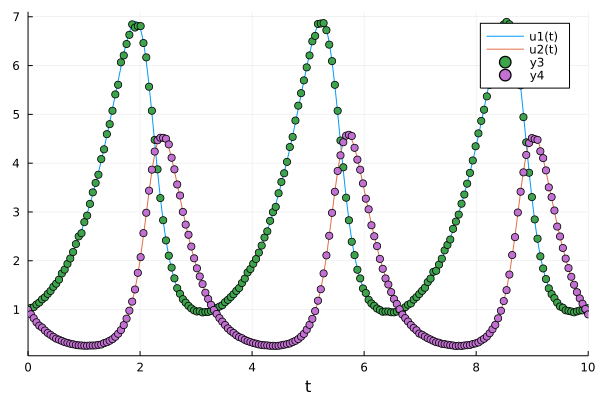

In [5]:
plot(sol)
scatter!(ts, data)

We can simply call `build_loss_objective()` to build a loss function for the ODE problem with the data.

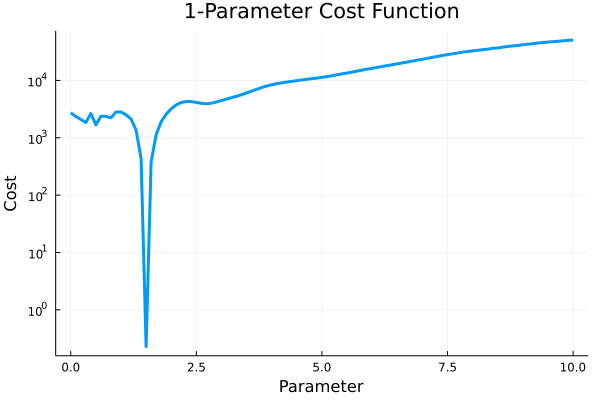

In [6]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(collect(ts), transpose(data)), maxiters=10000, verbose=false)

vals = 0.0:0.1:10.0

plot(cost_function, vals, lw = 3, label=false, yscale=:log10,
     xaxis = "Parameter", yaxis = "Cost", title = "1-Parameter Cost Function"
)

The cost function can be used with compatible optimizers. For instance, the ones from `Optim.jl`:

In [7]:
result = Optim.optimize(cost_function, 0.0, 10.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 10.000000]
 * Minimizer: 1.499890e+00
 * Minimum: 2.278473e-01
 * Iterations: 24
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 25

In [8]:
result.minimizer

1.4998896351464828

We have recovered the true parameter of 1.5!